# Autoencoder and Transformer Architectures

# Part II: Autoencoders for Anomaly Detection [30 points]

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.graph_objs as go
import torch
import random
import numpy as np
import torchvision
import gc
import tqdm
from torchinfo import summary
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchinfo import summary
import torch.optim as lr_scheduler
import torch.backends.cudnn as cudnn 
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from PIL import Image
import os
cudnn.benchmark = True
plt.ion() 

/Users/radhikasingh/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/radhikasingh/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <32D95B5B-8DE9-3BF9-9415-0B11B00E776F> /Users/radhikasingh/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <ED5B7495-D9A3-3875-A01B-C86976E4F5BB> /Users/radhikasingh/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
df=pd.read_csv(r'harddrive.csv').sample(30000)
df.head()

date   serial_number                 model  capacity_bytes  \
1257385  2016-01-21        Z3025L99           ST4000DM000   1.976651e-311   
2326476  2016-04-16        W3009HD0           ST4000DM000   1.976651e-311   
2978085  2016-04-26  PL1331LAHE0U2H  HGST HMS5C4040BLE640   1.976651e-311   
2544138  2016-04-20        W300BQXR           ST4000DM000   1.976651e-311   
1171656  2016-01-20        Z4D0681M           ST6000DX000   2.964974e-311   

         failure  smart_1_normalized  smart_1_raw  smart_2_normalized  \
1257385        0                 115     96854032                 NaN   
2326476        0                 115     95270352                 NaN   
2978085        0                 100            0               134.0   
2544138        0                 114     82142320                 NaN   
1171656        0                 114     67513973                 NaN   

         smart_2_raw  smart_3_normalized  ...  smart_250_normalized  \
1257385          NaN                  97  ...                   NaN   
2326476          NaN                  91  ...                   NaN   
2978085        101.0                 100  ...                   NaN   
2544138          NaN                  92  ...                   NaN   
1171656          NaN                  90  ...                   NaN   

         smart_250_raw  smart_251_normalized  smart_251_raw  \
1257385            NaN                   NaN            NaN   
2326476            NaN                   NaN            NaN   
2978085            NaN                   NaN            NaN   
2544138            NaN                   NaN            NaN   
1171656            NaN                   NaN            NaN   

         smart_252_normalized  smart_252_raw  smart_254_normalized  \
1257385                   NaN            NaN                   NaN   
2326476                   NaN            NaN                   NaN   
2978085                   NaN            NaN                   NaN   
2544138                   NaN            NaN                   NaN   
1171656                   NaN            NaN                   NaN   

         smart_254_raw  smart_255_normalized  smart_255_raw  
1257385            NaN                   NaN            NaN  
2326476            NaN                   NaN            NaN  
2978085            NaN                   NaN            NaN  
2544138            NaN                   NaN            NaN  
1171656            NaN                   NaN            NaN  

[5 rows x 95 columns]

In [3]:
df.describe()

capacity_bytes     failure  smart_1_normalized   smart_1_raw  \
count    3.000000e+04  30000.0000        30000.000000  3.000000e+04   
mean    1.852564e-311      0.0001          112.330467  6.890538e+07   
std      0.000000e+00      0.0100           18.936418  8.004681e+07   
min     3.953828e-313      0.0000           59.000000  0.000000e+00   
25%     1.976651e-311      0.0000          100.000000  0.000000e+00   
50%     1.976651e-311      0.0000          112.000000  3.074733e+07   
75%     1.976651e-311      0.0000          117.000000  1.349845e+08   
max     3.953298e-311      1.0000          200.000000  3.858809e+08   

       smart_2_normalized   smart_2_raw  smart_3_normalized   smart_3_raw  \
count        11803.000000  11803.000000        30000.000000  30000.000000   
mean           128.655427     75.059985          105.361567    368.883967   
std             24.614571     45.543309           18.845633   1104.509098   
min            100.000000      0.000000           86.000000      0.000000   
25%            131.000000      0.000000           94.000000      0.000000   
50%            133.000000    100.000000           98.000000      0.000000   
75%            134.000000    104.000000          114.000000    543.000000   
max            252.000000    187.000000          253.000000   9683.000000   

       smart_4_normalized   smart_4_raw  ...  smart_250_normalized  \
count        30000.000000  30000.000000  ...                  36.0   
mean            99.997867     13.970233  ...                   1.0   
std              0.179434    187.101731  ...                   0.0   
min             74.000000      1.000000  ...                   1.0   
25%            100.000000      4.000000  ...                   1.0   
50%            100.000000      7.000000  ...                   1.0   
75%            100.000000     15.000000  ...                   1.0   
max            100.000000  26674.000000  ...                   1.0   

       smart_250_raw  smart_251_normalized  smart_251_raw  \
count   3.600000e+01             36.000000   3.600000e+01   
mean    1.004224e+08             12.000000   1.894792e+08   
std     7.428630e+07             31.554035   1.539230e+08   
min     2.566770e+05              1.000000   9.180000e+02   
25%     1.461605e+07              1.000000   7.030648e+06   
50%     1.373557e+08              1.000000   2.642689e+08   
75%     1.687936e+08              1.000000   3.314115e+08   
max     1.946133e+08            100.000000   3.768643e+08   

       smart_252_normalized  smart_252_raw  smart_254_normalized  \
count             36.000000   3.600000e+01             83.000000   
mean              25.750000   8.697528e+07            114.457831   
std               43.476348   7.060038e+07             35.381303   
min                1.000000   0.000000e+00            100.000000   
25%                1.000000   3.181986e+06            100.000000   
50%                1.000000   1.220637e+08            100.000000   
75%               25.750000   1.518106e+08            100.000000   
max              100.000000   1.740681e+08            200.000000   

       smart_254_raw  smart_255_normalized  smart_255_raw  
count           83.0                   0.0            0.0  
mean             0.0                   NaN            NaN  
std              0.0                   NaN            NaN  
min              0.0                   NaN            NaN  
25%              0.0                   NaN            NaN  
50%              0.0                   NaN            NaN  
75%              0.0                   NaN            NaN  
max              0.0                   NaN            NaN  

[8 rows x 92 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1257385 to 2116253
Data columns (total 95 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  30000 non-null  object 
 1   serial_number         30000 non-null  object 
 2   model                 30000 non-null  object 
 3   capacity_bytes        30000 non-null  float64
 4   failure               30000 non-null  int64  
 5   smart_1_normalized    30000 non-null  int64  
 6   smart_1_raw           30000 non-null  int64  
 7   smart_2_normalized    11803 non-null  float64
 8   smart_2_raw           11803 non-null  float64
 9   smart_3_normalized    30000 non-null  int64  
 10  smart_3_raw           30000 non-null  int64  
 11  smart_4_normalized    30000 non-null  int64  
 12  smart_4_raw           30000 non-null  int64  
 13  smart_5_normalized    30000 non-null  int64  
 14  smart_5_raw           30000 non-null  int64  
 15  smart_7_normaliz

In [5]:
df.shape

(30000, 95)

In [6]:
#df=df.head(200000)

In [7]:
df.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized', 'smart_3_raw',
       'smart_4_normalized', 'smart_4_raw', 'smart_5_normalized',
       'smart_5_raw', 'smart_7_normalized', 'smart_7_raw',
       'smart_8_normalized', 'smart_8_raw', 'smart_9_normalized',
       'smart_9_raw', 'smart_10_normalized', 'smart_10_raw',
       'smart_11_normalized', 'smart_11_raw', 'smart_12_normalized',
       'smart_12_raw', 'smart_13_normalized', 'smart_13_raw',
       'smart_15_normalized', 'smart_15_raw', 'smart_22_normalized',
       'smart_22_raw', 'smart_183_normalized', 'smart_183_raw',
       'smart_184_normalized', 'smart_184_raw', 'smart_187_normalized',
       'smart_187_raw', 'smart_188_normalized', 'smart_188_raw',
       'smart_189_normalized', 'smart_189_raw', 'smart_190_normalized',
       'smart_190_raw', 'smart_191_normalized', 'smart_191_raw',
       'smart_1

In [8]:
df.dtypes

date                     object
serial_number            object
model                    object
capacity_bytes          float64
failure                   int64
                         ...   
smart_252_raw           float64
smart_254_normalized    float64
smart_254_raw           float64
smart_255_normalized    float64
smart_255_raw           float64
Length: 95, dtype: object

In [9]:
df.drop_duplicates()

date    serial_number                    model  capacity_bytes  \
1257385  2016-01-21         Z3025L99              ST4000DM000   1.976651e-311   
2326476  2016-04-16         W3009HD0              ST4000DM000   1.976651e-311   
2978085  2016-04-26   PL1331LAHE0U2H     HGST HMS5C4040BLE640   1.976651e-311   
2544138  2016-04-20         W300BQXR              ST4000DM000   1.976651e-311   
1171656  2016-01-20         Z4D0681M              ST6000DX000   2.964974e-311   
...             ...              ...                      ...             ...   
422844   2016-01-07   PL1331LAGRS2PH     HGST HMS5C4040ALE640   1.976651e-311   
2274139  2016-04-15   MJ1311YNG3K4MA  Hitachi HDS5C3030ALA630   1.482490e-311   
524737   2016-01-09  WD-WMC1T1203664             WDC WD30EFRX   1.482490e-311   
2521405  2016-04-19         S301GNE3              ST4000DM000   1.976651e-311   
2116253  2016-04-13   MJ1311YNG3HETA  Hitachi HDS5C3030ALA630   1.482490e-311   

         failure  smart_1_normalized  smart_1_raw  smart_2_normalized  \
1257385        0                 115     96854032                 NaN   
2326476        0                 115     95270352                 NaN   
2978085        0                 100            0               134.0   
2544138        0                 114     82142320                 NaN   
1171656        0                 114     67513973                 NaN   
...          ...                 ...          ...                 ...   
422844         0                 100            0               133.0   
2274139        0                 100            0               100.0   
524737         0                 200            0                 NaN   
2521405        0                 118    184805336                 NaN   
2116253        0                 100            0               136.0   

         smart_2_raw  smart_3_normalized  ...  smart_250_normalized  \
1257385          NaN                  97  ...                   NaN   
2326476          NaN                  91  ...                   NaN   
2978085        101.0                 100  ...                   NaN   
2544138          NaN                  92  ...                   NaN   
1171656          NaN                  90  ...                   NaN   
...              ...                 ...  ...                   ...   
422844         104.0                 100  ...                   NaN   
2274139          0.0                 136  ...                   NaN   
524737           NaN                 176  ...                   NaN   
2521405          NaN                  98  ...                   NaN   
2116253        101.0                 125  ...                   NaN   

         smart_250_raw  smart_251_normalized  smart_251_raw  \
1257385            NaN                   NaN            NaN   
2326476            NaN                   NaN            NaN   
2978085            NaN                   NaN            NaN   
2544138            NaN                   NaN            NaN   
1171656            NaN                   NaN            NaN   
...                ...                   ...            ...   
422844             NaN                   NaN            NaN   
2274139            NaN                   NaN            NaN   
524737             NaN                   NaN            NaN   
2521405            NaN                   NaN            NaN   
2116253            NaN                   NaN            NaN   

         smart_252_normalized  smart_252_raw  smart_254_normalized  \
1257385                   NaN            NaN                   NaN   
2326476                   NaN            NaN                   NaN   
2978085                   NaN            NaN                   NaN   
2544138                   NaN            NaN                   NaN   
1171656                   NaN            NaN                   NaN   
...                       ...            ...                   ...   
422844                    NaN            NaN                   Na

In [10]:
for i in df:
  print(f"The no of unique elements for {i} column in the Harddrive dataset is {df[i].nunique()}.")

The no of unique elements for date column in the Harddrive dataset is 50.
The no of unique elements for serial_number column in the Harddrive dataset is 24016.
The no of unique elements for model column in the Harddrive dataset is 52.
The no of unique elements for capacity_bytes column in the Harddrive dataset is 13.
The no of unique elements for failure column in the Harddrive dataset is 2.
The no of unique elements for smart_1_normalized column in the Harddrive dataset is 44.
The no of unique elements for smart_1_raw column in the Harddrive dataset is 17263.
The no of unique elements for smart_2_normalized column in the Harddrive dataset is 20.
The no of unique elements for smart_2_raw column in the Harddrive dataset is 61.
The no of unique elements for smart_3_normalized column in the Harddrive dataset is 120.
The no of unique elements for smart_3_raw column in the Harddrive dataset is 857.
The no of unique elements for smart_4_normalized column in the Harddrive dataset is 6.
The no

In [11]:
df.isnull().sum()

date                        0
serial_number               0
model                       0
capacity_bytes              0
failure                     0
                        ...  
smart_252_raw           29964
smart_254_normalized    29917
smart_254_raw           29917
smart_255_normalized    30000
smart_255_raw           30000
Length: 95, dtype: int64

In [12]:
df['model'].unique()

array(['ST4000DM000', 'HGST HMS5C4040BLE640', 'ST6000DX000',
       'HGST HMS5C4040ALE640', 'Hitachi HDS5C4040ALE630',
       'Hitachi HDS722020ALA330', 'WDC WD5000LPVX', 'WDC WD60EFRX',
       'ST4000DX000', 'Hitachi HDS5C3030ALA630', 'ST500LM012 HN',
       'WDC WD20EFRX', 'TOSHIBA MD04ABA400V', 'Hitachi HDS723030ALA640',
       'ST31500541AS', 'WDC WD30EFRX', 'ST320LT007', 'ST9250315AS',
       'HGST HDS5C4040ALE630', 'HGST HUH728080ALE600', 'WDC WD1600AAJS',
       'TOSHIBA DT01ACA300', 'HGST HDS724040ALE640', 'WDC WD5000BPKT',
       'WDC WD10EADS', 'WDC WD40EFRX', 'TOSHIBA MD04ABA500V',
       'WDC WD3200BEKX', 'ST3160316AS', 'ST3160318AS', 'ST250LM004 HN',
       'WDC WD800AAJS', 'WDC WD2500BPVT', 'Hitachi HDS723030BLE640',
       'ST4000DX002', 'WDC WD800AAJB', 'ST2000VN000', 'WDC WD800BB',
       'ST9320325AS', 'Hitachi HDS724040ALE640', 'WDC WD1600AAJB',
       'WDC WD2500AAJB', 'WDC WD3200BEKT', 'ST3500320AS', 'ST250LT007',
       'Hitachi HDS723020BLA642', 'WDC WD10EARX', '

In [13]:
drive_model_mapping = {'Hitachi HDS5C3030ALA630':1, 'ST4000DM000':2, 'WDC WD30EFRX':3,
'Hitachi HDS5C4040ALE630':4, 'HGST HMS5C4040ALE640':5,'HGST HMS5C4040BLE640':6, 'ST6000DX000':7, 
'Hitachi HDS723030ALA640':8,'Hitachi HDS722020ALA330':9, 'ST31500541AS':10, 'ST4000DX000':11,
           'WDC WD60EFRX':12, 'WDC WD5000LPVX':13, 'HGST HUH728080ALE600':14,
'WDC WD1600AAJS':15, 'ST320LT007':16, 'ST500LM012 HN':17,'TOSHIBA MD04ABA500V':18, 'ST9320325AS':19, 
'TOSHIBA MD04ABA400V':20,
'TOSHIBA DT01ACA300':21, 'HGST HDS724040ALE640':22, 'ST3160318AS':23,'WDC WD20EFRX':24, 'ST9250315AS':25, 
           'ST3160316AS':26,'Hitachi HDS724040ALE640':27, 'Hitachi HDS723020BLA642':28,
           'HGST HDS5C4040ALE630':29, 'ST2000VN000':30, 'WDC WD3200AAJB':31,
'WDC WD40EFRX':32, 'WDC WD800AAJS':33, 'WDC WD3200BEKX':34, 'WDC WD800JB':35,'WDC WD5000BPKT':36, 
           'ST250LM004 HN':37, 
'Hitachi HDT725025VLA380':38,'WDC WD1600AAJB':39, 'Hitachi HDS723030BLE640':40, 'WDC WD800AAJB':41,
           'WDC WD800LB':42, 
'Hitachi HDS5C3030BLE630':43, 'WDC WD3200BEKT':44,'WDC WD5002ABYS':45, 'ST250LT007':46, 'WDC WD2500AAJS':47, 
           'WDC WD800BB':48,
'WDC WD2500BEVT':49, 'WDC WD2500BPVT':50, 'WDC WD5003ABYX':51,'WDC WD2500AAJB':52, 'WDC WD3200LPVX':53, 
           'ST31500341AS':54,
'WDC WD3200AAJS':55, 'WDC WD3200AAKS':56, 'WDC WD800JD':57,
           'SAMSUNG HD154UI':69, 'ST3500320AS':58, 'WDC WD1600BPVT':59, 'WDC WD10EADS':60,
'WDC WD10EACS':61, 'WDC WD10EARS':62, 'WDC WD10EADX':63, 'WDC WD10EARX':64,'ST4000DX002':65, 'WDC WD10EALS':66, 
           'WDC WD1001FALS':67, 'WDC WD15EARS':68}


df['drive_model_mapped'] = df['model'].map(drive_model_mapping)


df.head()

date   serial_number                 model  capacity_bytes  \
1257385  2016-01-21        Z3025L99           ST4000DM000   1.976651e-311   
2326476  2016-04-16        W3009HD0           ST4000DM000   1.976651e-311   
2978085  2016-04-26  PL1331LAHE0U2H  HGST HMS5C4040BLE640   1.976651e-311   
2544138  2016-04-20        W300BQXR           ST4000DM000   1.976651e-311   
1171656  2016-01-20        Z4D0681M           ST6000DX000   2.964974e-311   

         failure  smart_1_normalized  smart_1_raw  smart_2_normalized  \
1257385        0                 115     96854032                 NaN   
2326476        0                 115     95270352                 NaN   
2978085        0                 100            0               134.0   
2544138        0                 114     82142320                 NaN   
1171656        0                 114     67513973                 NaN   

         smart_2_raw  smart_3_normalized  ...  smart_250_raw  \
1257385          NaN                  97  ...            NaN   
2326476          NaN                  91  ...            NaN   
2978085        101.0                 100  ...            NaN   
2544138          NaN                  92  ...            NaN   
1171656          NaN                  90  ...            NaN   

         smart_251_normalized  smart_251_raw  smart_252_normalized  \
1257385                   NaN            NaN                   NaN   
2326476                   NaN            NaN                   NaN   
2978085                   NaN            NaN                   NaN   
2544138                   NaN            NaN                   NaN   
1171656                   NaN            NaN                   NaN   

         smart_252_raw  smart_254_normalized  smart_254_raw  \
1257385            NaN                   NaN            NaN   
2326476            NaN                   NaN            NaN   
2978085            NaN                   NaN            NaN   
2544138            NaN                   NaN            NaN   
1171656            NaN                   NaN            NaN   

         smart_255_normalized  smart_255_raw  drive_model_mapped  
1257385                   NaN            NaN                   2  
2326476                   NaN            NaN                   2  
2978085                   NaN            NaN                   6  
2544138                   NaN            NaN                   2  
1171656                   NaN            NaN                   7  

[5 rows x 96 columns]

In [14]:
print("number of hard drives:", df.index.nunique()) 
print("number of different hard drives:", df['drive_model_mapped'].nunique())
#print("number of failed hard drives:", df.loc[df.failure==1])

number of hard drives: 30000
number of different hard drives: 52


In [15]:
print("Mean of all columns:", df.select_dtypes(include=['number']).mean())
print("Median of all columns:", df.select_dtypes(include=['number']).median())
print("Mode of all columns:", df.select_dtypes(include=['number']).mode().iloc[0] )

Mean of all columns: capacity_bytes          1.852564e-311
failure                  1.000000e-04
smart_1_normalized       1.123305e+02
smart_1_raw              6.890538e+07
smart_2_normalized       1.286554e+02
                            ...      
smart_254_normalized     1.144578e+02
smart_254_raw            0.000000e+00
smart_255_normalized              NaN
smart_255_raw                     NaN
drive_model_mapped       4.070467e+00
Length: 93, dtype: float64
Median of all columns: capacity_bytes          1.976651e-311
failure                  0.000000e+00
smart_1_normalized       1.120000e+02
smart_1_raw              3.074733e+07
smart_2_normalized       1.330000e+02
                            ...      
smart_254_normalized     1.000000e+02
smart_254_raw            0.000000e+00
smart_255_normalized              NaN
smart_255_raw                     NaN
drive_model_mapped       2.000000e+00
Length: 93, dtype: float64
Mode of all columns: capacity_bytes          1.976651e-311
failure

In [16]:
df.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized', 'smart_3_raw',
       'smart_4_normalized', 'smart_4_raw', 'smart_5_normalized',
       'smart_5_raw', 'smart_7_normalized', 'smart_7_raw',
       'smart_8_normalized', 'smart_8_raw', 'smart_9_normalized',
       'smart_9_raw', 'smart_10_normalized', 'smart_10_raw',
       'smart_11_normalized', 'smart_11_raw', 'smart_12_normalized',
       'smart_12_raw', 'smart_13_normalized', 'smart_13_raw',
       'smart_15_normalized', 'smart_15_raw', 'smart_22_normalized',
       'smart_22_raw', 'smart_183_normalized', 'smart_183_raw',
       'smart_184_normalized', 'smart_184_raw', 'smart_187_normalized',
       'smart_187_raw', 'smart_188_normalized', 'smart_188_raw',
       'smart_189_normalized', 'smart_189_raw', 'smart_190_normalized',
       'smart_190_raw', 'smart_191_normalized', 'smart_191_raw',
       'smart_1

In [ ]:
df.head(10)

In [17]:
df=df[['smart_1_normalized', 'smart_2_normalized', 'smart_3_normalized','smart_4_normalized',
       'smart_5_normalized', 'smart_7_normalized','smart_8_normalized',
       'smart_9_normalized', 'smart_10_normalized', 'smart_11_normalized', 'smart_12_normalized',
       'smart_13_normalized','smart_15_normalized', 'smart_22_normalized', 'smart_183_normalized',
       'smart_184_normalized', 'smart_187_normalized','smart_188_normalized', 'smart_189_normalized', 
       'smart_190_normalized','smart_191_normalized', 'smart_192_normalized', 'smart_193_normalized',
       'smart_194_normalized', 'smart_195_normalized','smart_196_normalized', 'smart_197_normalized',
       'smart_198_normalized', 'smart_199_normalized', 'smart_200_normalized', 'smart_201_normalized',
       'smart_220_normalized', 'smart_222_normalized','smart_223_normalized', 'smart_224_normalized',
       'smart_225_normalized','smart_226_normalized', 'smart_240_normalized', 'smart_241_normalized', 
       'smart_242_normalized',  'smart_250_normalized','smart_251_normalized', 'smart_252_normalized', 
       'smart_254_normalized', 'smart_255_normalized']]

In [18]:
#for i in df.columns:
#    if i != df.columns[0]:
#        df[i].fillna(df[i].median(), inplace=True)
df.fillna(0,inplace=True)

In [19]:
df.isnull().sum()

smart_1_normalized      0
smart_2_normalized      0
smart_3_normalized      0
smart_4_normalized      0
smart_5_normalized      0
smart_7_normalized      0
smart_8_normalized      0
smart_9_normalized      0
smart_10_normalized     0
smart_11_normalized     0
smart_12_normalized     0
smart_13_normalized     0
smart_15_normalized     0
smart_22_normalized     0
smart_183_normalized    0
smart_184_normalized    0
smart_187_normalized    0
smart_188_normalized    0
smart_189_normalized    0
smart_190_normalized    0
smart_191_normalized    0
smart_192_normalized    0
smart_193_normalized    0
smart_194_normalized    0
smart_195_normalized    0
smart_196_normalized    0
smart_197_normalized    0
smart_198_normalized    0
smart_199_normalized    0
smart_200_normalized    0
smart_201_normalized    0
smart_220_normalized    0
smart_222_normalized    0
smart_223_normalized    0
smart_224_normalized    0
smart_225_normalized    0
smart_226_normalized    0
smart_240_normalized    0
smart_241_no

In [20]:
#df.drop(columns=['date','drive_model_mapped','capacity_bytes','failure'], inplace=True)# 

In [21]:
df.describe()

smart_1_normalized  smart_2_normalized  smart_3_normalized  \
count        30000.000000        30000.000000        30000.000000   
mean           112.330467           50.617333          105.361567   
std             18.936418           64.719177           18.845633   
min             59.000000            0.000000           86.000000   
25%            100.000000            0.000000           94.000000   
50%            112.000000            0.000000           98.000000   
75%            117.000000          133.000000          114.000000   
max            200.000000          252.000000          253.000000   

       smart_4_normalized  smart_5_normalized  smart_7_normalized  \
count        30000.000000        30000.000000        30000.000000   
mean            99.997867          105.201967           92.960267   
std              0.179434           23.962042           21.949784   
min             74.000000           22.000000           41.000000   
25%            100.000000          100.000000           83.000000   
50%            100.000000          100.000000           87.000000   
75%            100.000000          100.000000          100.000000   
max            100.000000          252.000000          252.000000   

       smart_8_normalized  smart_9_normalized  smart_10_normalized  \
count         30000.00000        30000.000000         30000.000000   
mean             45.54160           92.014933           101.518167   
std              58.47816            8.312485            15.125154   
min               0.00000            1.000000            75.000000   
25%               0.00000           89.000000           100.000000   
50%               0.00000           95.000000           100.000000   
75%             111.00000           98.000000           100.000000   
max             252.00000          100.000000           252.000000   

       smart_11_normalized  ...  smart_225_normalized  smart_226_normalized  \
count         30000.000000  ...          30000.000000           30000.00000   
mean              4.726967  ...              0.906667               0.29000   
std              21.401370  ...              9.063095               5.37744   
min               0.000000  ...              0.000000               0.00000   
25%               0.000000  ...              0.000000               0.00000   
50%               0.000000  ...              0.000000               0.00000   
75%               0.000000  ...              0.000000               0.00000   
max             252.000000  ...            100.000000             100.00000   

       smart_240_normalized  smart_241_normalized  smart_242_normalized  \
count          30000.000000          30000.000000          30000.000000   
mean              57.238867             56.913333             56.913333   
std               49.458222             49.601289             49.601289   
min                0.000000              0.000000              0.000000   
25%                0.000000              0.000000              0.000000   
50%              100.000000            100.000000            100.000000   
75%              100.000000            100.000000            100.000000   
max              100.000000            200.000000            200.000000   

       smart_250_normalized  smart_251_normalized  smart_252_normalized  \
count          30000.000000          30000.000000          30000.000000   
mean               0.001200              0.014400              0.030900   
std                0.034621              1.155092              1.732064   
min                0.000000              0.000000              0.000000   
25%                0.000000              0.000000              0.000000   
50%                0.000000              0.000000              0.000000   
75%                0.000000              0.000000              0.000000   
max                1.000000            100.000000            100.000000   

       smart_254_normalized  smart_255_normalized  
count          3

# Standardization

In [22]:
df = (df - df.mean()) / (df.std())

In [23]:
df.shape

(30000, 45)

In [24]:
df.head()

smart_1_normalized  smart_2_normalized  smart_3_normalized  \
1257385            0.140974           -0.782107           -0.443687   
2326476            0.140974           -0.782107           -0.762063   
2978085           -0.651151            1.288377           -0.284499   
2544138            0.088165           -0.782107           -0.709001   
1171656            0.088165           -0.782107           -0.815126   

         smart_4_normalized  smart_5_normalized  smart_7_normalized  \
1257385            0.011889           -0.217092           -0.271541   
2326476            0.011889           -0.217092           -0.271541   
2978085            0.011889           -0.217092            0.320720   
2544138            0.011889           -0.217092           -0.271541   
1171656            0.011889           -0.217092           -0.408217   

         smart_8_normalized  smart_9_normalized  smart_10_normalized  \
1257385           -0.778780           -0.242398            -0.100374   
2326476           -0.778780           -2.407816            -0.100374   
2978085            1.153566            0.960611            -0.100374   
2544138           -0.778780           -2.287515            -0.100374   
1171656           -0.778780           -0.001796            -0.100374   

         smart_11_normalized  ...  smart_225_normalized  smart_226_normalized  \
1257385            -0.220872  ...             -0.100039             -0.053929   
2326476            -0.220872  ...             -0.100039             -0.053929   
2978085            -0.220872  ...             -0.100039             -0.053929   
2544138            -0.220872  ...             -0.100039             -0.053929   
1171656            -0.220872  ...             -0.100039             -0.053929   

         smart_240_normalized  smart_241_normalized  smart_242_normalized  \
1257385              0.864591              0.868660              0.868660   
2326476              0.864591              0.868660              0.868660   
2978085             -1.157318             -1.147416             -1.147416   
2544138              0.864591              0.868660              0.868660   
1171656              0.864591              0.868660              0.868660   

         smart_250_normalized  smart_251_normalized  smart_252_normalized  \
1257385             -0.034661             -0.012467              -0.01784   
2326476             -0.034661             -0.012467              -0.01784   
2978085             -0.034661             -0.012467              -0.01784   
2544138             -0.034661             -0.012467              -0.01784   
1171656             -0.034661             -0.012467              -0.01784   

         smart_254_normalized  smart_255_normalized  
1257385             -0.050342                   NaN  
2326476             -0.050342                   NaN  
2978085             -0.050342                   NaN  
2544138             -0.050342                   NaN  
1171656             -0.050342                   NaN  

[5 rows x 45 columns]

In [26]:
df.head()

smart_1_normalized  smart_2_normalized  smart_3_normalized  \
1257385            0.140974           -0.782107           -0.443687   
2326476            0.140974           -0.782107           -0.762063   
2978085           -0.651151            1.288377           -0.284499   
2544138            0.088165           -0.782107           -0.709001   
1171656            0.088165           -0.782107           -0.815126   

         smart_4_normalized  smart_5_normalized  smart_7_normalized  \
1257385            0.011889           -0.217092           -0.271541   
2326476            0.011889           -0.217092           -0.271541   
2978085            0.011889           -0.217092            0.320720   
2544138            0.011889           -0.217092           -0.271541   
1171656            0.011889           -0.217092           -0.408217   

         smart_8_normalized  smart_9_normalized  smart_10_normalized  \
1257385           -0.778780           -0.242398            -0.100374   
2326476           -0.778780           -2.407816            -0.100374   
2978085            1.153566            0.960611            -0.100374   
2544138           -0.778780           -2.287515            -0.100374   
1171656           -0.778780           -0.001796            -0.100374   

         smart_11_normalized  ...  smart_225_normalized  smart_226_normalized  \
1257385            -0.220872  ...             -0.100039             -0.053929   
2326476            -0.220872  ...             -0.100039             -0.053929   
2978085            -0.220872  ...             -0.100039             -0.053929   
2544138            -0.220872  ...             -0.100039             -0.053929   
1171656            -0.220872  ...             -0.100039             -0.053929   

         smart_240_normalized  smart_241_normalized  smart_242_normalized  \
1257385              0.864591              0.868660              0.868660   
2326476              0.864591              0.868660              0.868660   
2978085             -1.157318             -1.147416             -1.147416   
2544138              0.864591              0.868660              0.868660   
1171656              0.864591              0.868660              0.868660   

         smart_250_normalized  smart_251_normalized  smart_252_normalized  \
1257385             -0.034661             -0.012467              -0.01784   
2326476             -0.034661             -0.012467              -0.01784   
2978085             -0.034661             -0.012467              -0.01784   
2544138             -0.034661             -0.012467              -0.01784   
1171656             -0.034661             -0.012467              -0.01784   

         smart_254_normalized  smart_255_normalized  
1257385             -0.050342                   0.0  
2326476             -0.050342                   0.0  
2978085             -0.050342                   0.0  
2544138             -0.050342                   0.0  
1171656             -0.050342                   0.0  

[5 rows x 45 columns]

In [ ]:
df.head()

In [27]:
df.drop(columns=['smart_15_normalized','smart_255_normalized'], inplace=True)

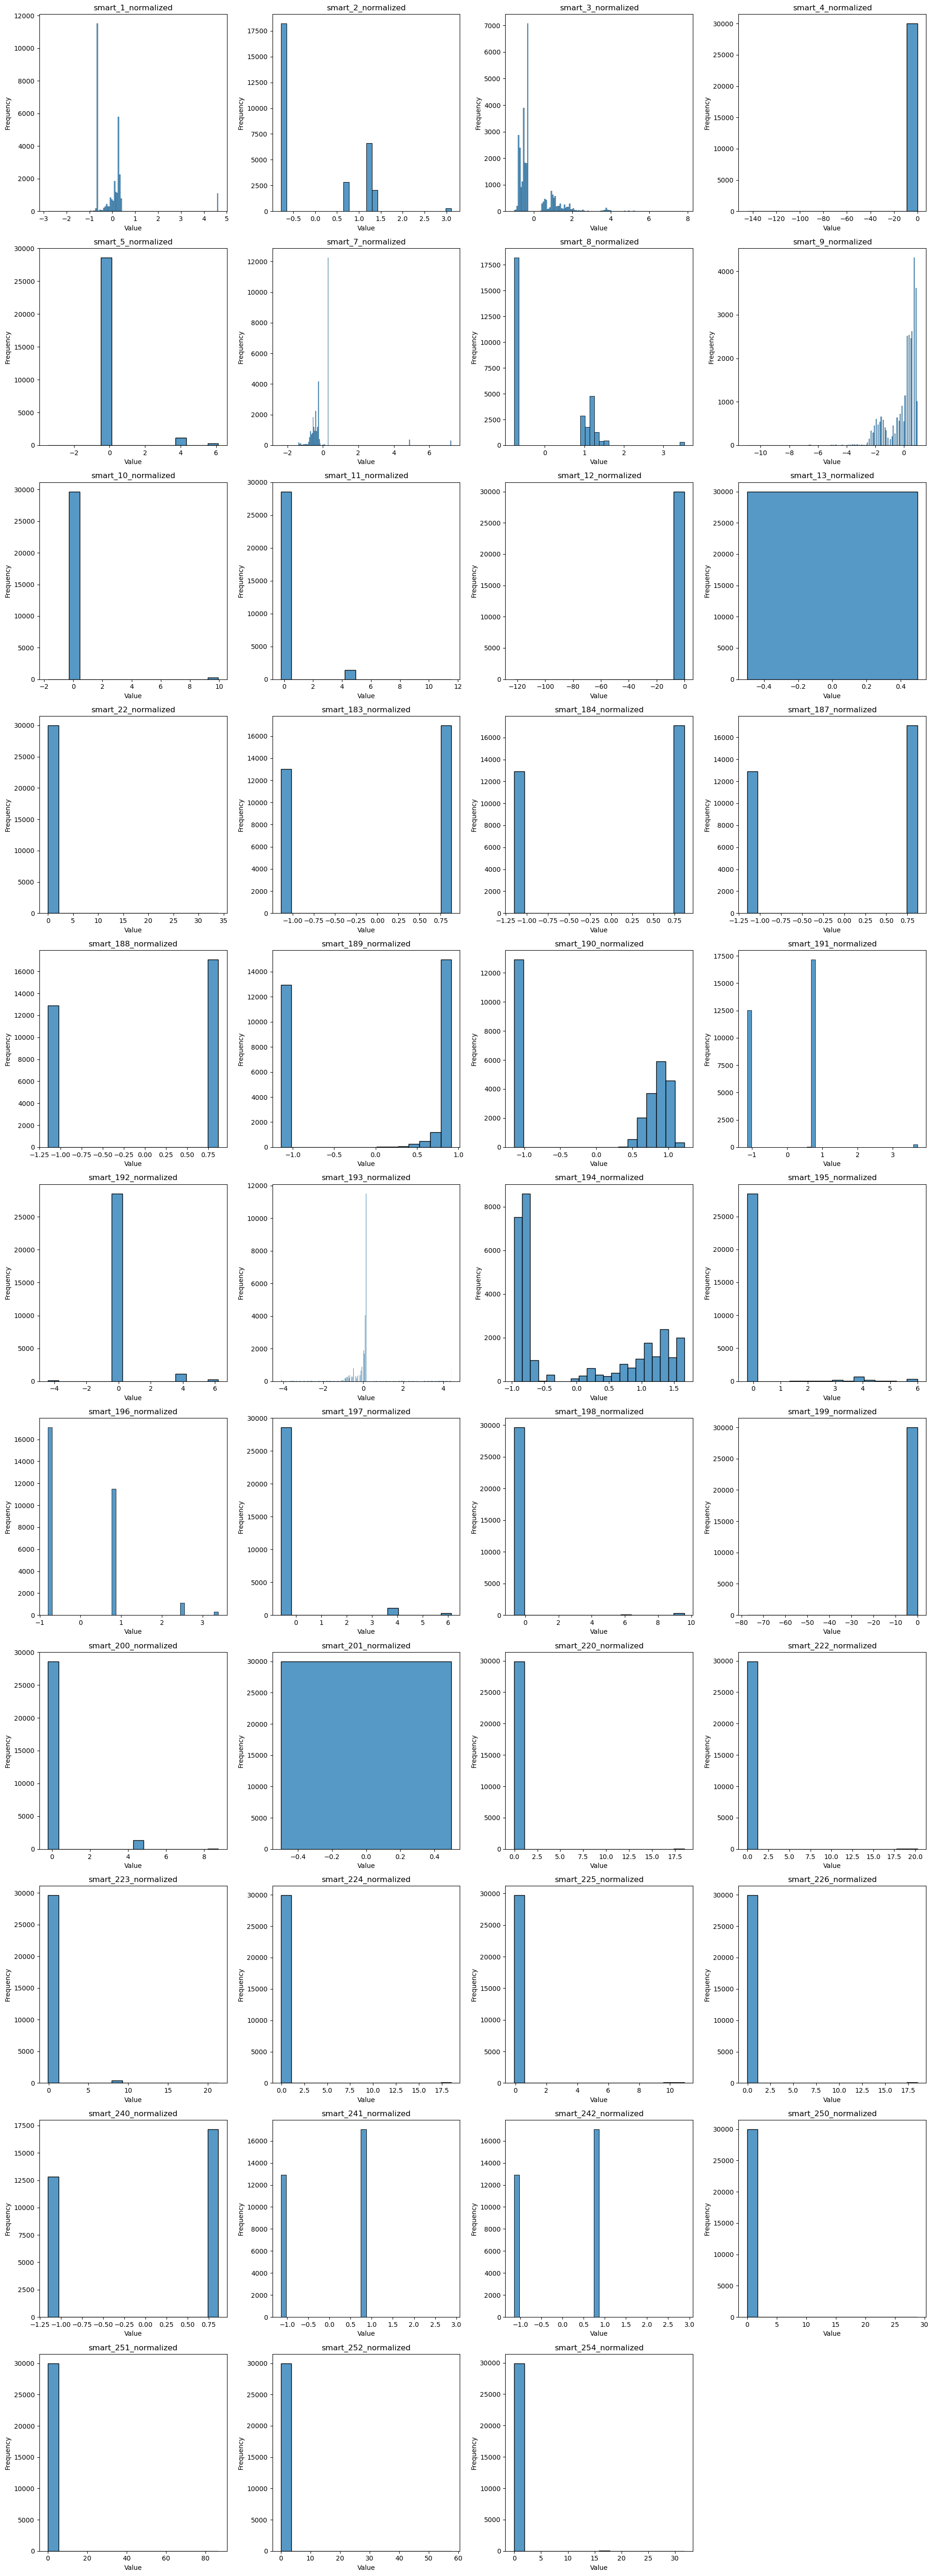

In [30]:
columns_to_plot = ['smart_1_normalized','smart_2_normalized','smart_3_normalized',
    'smart_4_normalized', 'smart_5_normalized', 'smart_7_normalized', 'smart_8_normalized', 'smart_9_normalized', 
                   'smart_10_normalized', 'smart_11_normalized', 'smart_12_normalized', 'smart_13_normalized', 'smart_22_normalized', 
                   'smart_183_normalized', 'smart_184_normalized', 'smart_187_normalized', 'smart_188_normalized', 'smart_189_normalized', 
                   'smart_190_normalized', 'smart_191_normalized', 'smart_192_normalized', 'smart_193_normalized', 'smart_194_normalized', 
                   'smart_195_normalized', 'smart_196_normalized', 'smart_197_normalized', 'smart_198_normalized', 'smart_199_normalized', 
                   'smart_200_normalized', 'smart_201_normalized', 'smart_220_normalized', 'smart_222_normalized', 'smart_223_normalized', 
                   'smart_224_normalized', 'smart_225_normalized', 'smart_226_normalized', 'smart_240_normalized', 'smart_241_normalized', 
                   'smart_242_normalized', 'smart_250_normalized', 'smart_251_normalized', 'smart_252_normalized', 'smart_254_normalized']

num_cols = 4
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols 
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
axs = axs.flatten()


for i, column in enumerate(columns_to_plot):
    sns.histplot(df[column], ax=axs[i])
    axs[i].set_title(column)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')


for j in range(len(columns_to_plot), num_cols*num_rows):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


'smart_22_normalized', 'smart_190_normalized', 'smart_193_normalized', 
         'smart_201_normalized', 'smart_220_normalized', 'smart_224_normalized', 
         'smart_226_normalized', 'smart_250_normalized', 'smart_10_normalized', 'smart_11_normalized',
        'smart_183_normalized', 'smart_184_normalized','smart_188_normalized',
        'smart_187_normalized', 'smart_199_normalized', 'smart_200_normalized', 
     'smart_241_normalized','smart_242_normalized','smart_254_normalized','capacity_bytes',
    'smart_12_normalized','smart_13_normalized', 'smart_194_normalized','smart_4_normalized',
                 'smart_251_normalized','end_date','date_diff','date_diff_days',
      'smart_195_normalized', 'smart_240_normalized','smart_225_normalized','smart_9_normalized' have similar frequency 

In [31]:
'''df.drop(columns=['smart_22_normalized', 'smart_190_normalized', 'smart_193_normalized', 
         'smart_201_normalized', 'smart_220_normalized', 'smart_224_normalized', 
         'smart_226_normalized', 'smart_250_normalized', 'smart_10_normalized', 'smart_11_normalized',
        'smart_183_normalized', 'smart_184_normalized','smart_188_normalized',
        'smart_187_normalized', 'smart_199_normalized', 'smart_200_normalized', 
     'smart_241_normalized','smart_242_normalized','smart_254_normalized','capacity_bytes',
    'smart_12_normalized','smart_13_normalized', 'smart_194_normalized','smart_4_normalized',
                 'smart_251_normalized','end_date','date_diff','date_diff_days',
      'smart_195_normalized', 'smart_240_normalized','smart_225_normalized','smart_9_normalized' ],inplace=True)'''

"df.drop(columns=['smart_22_normalized', 'smart_190_normalized', 'smart_193_normalized', \n         'smart_201_normalized', 'smart_220_normalized', 'smart_224_normalized', \n         'smart_226_normalized', 'smart_250_normalized', 'smart_10_normalized', 'smart_11_normalized',\n        'smart_183_normalized', 'smart_184_normalized','smart_188_normalized',\n        'smart_187_normalized', 'smart_199_normalized', 'smart_200_normalized', \n     'smart_241_normalized','smart_242_normalized','smart_254_normalized','capacity_bytes',\n    'smart_12_normalized','smart_13_normalized', 'smart_194_normalized','smart_4_normalized',\n                 'smart_251_normalized','end_date','date_diff','date_diff_days',\n      'smart_195_normalized', 'smart_240_normalized','smart_225_normalized','smart_9_normalized' ],inplace=True)"

capacity_bytes, end_date, date_diff ,
date_diff_days have 0 correlation that's why it is replaced at the top

In [32]:
#df.drop(columns=['date','smart_189_normalized', 'smart_191_normalized', 'smart_222_normalized', 
#         'smart_223_normalized', 'smart_252_normalized',  'smart_198_normalized', 'failure', 'smart_3_normalized'  ],inplace=True)

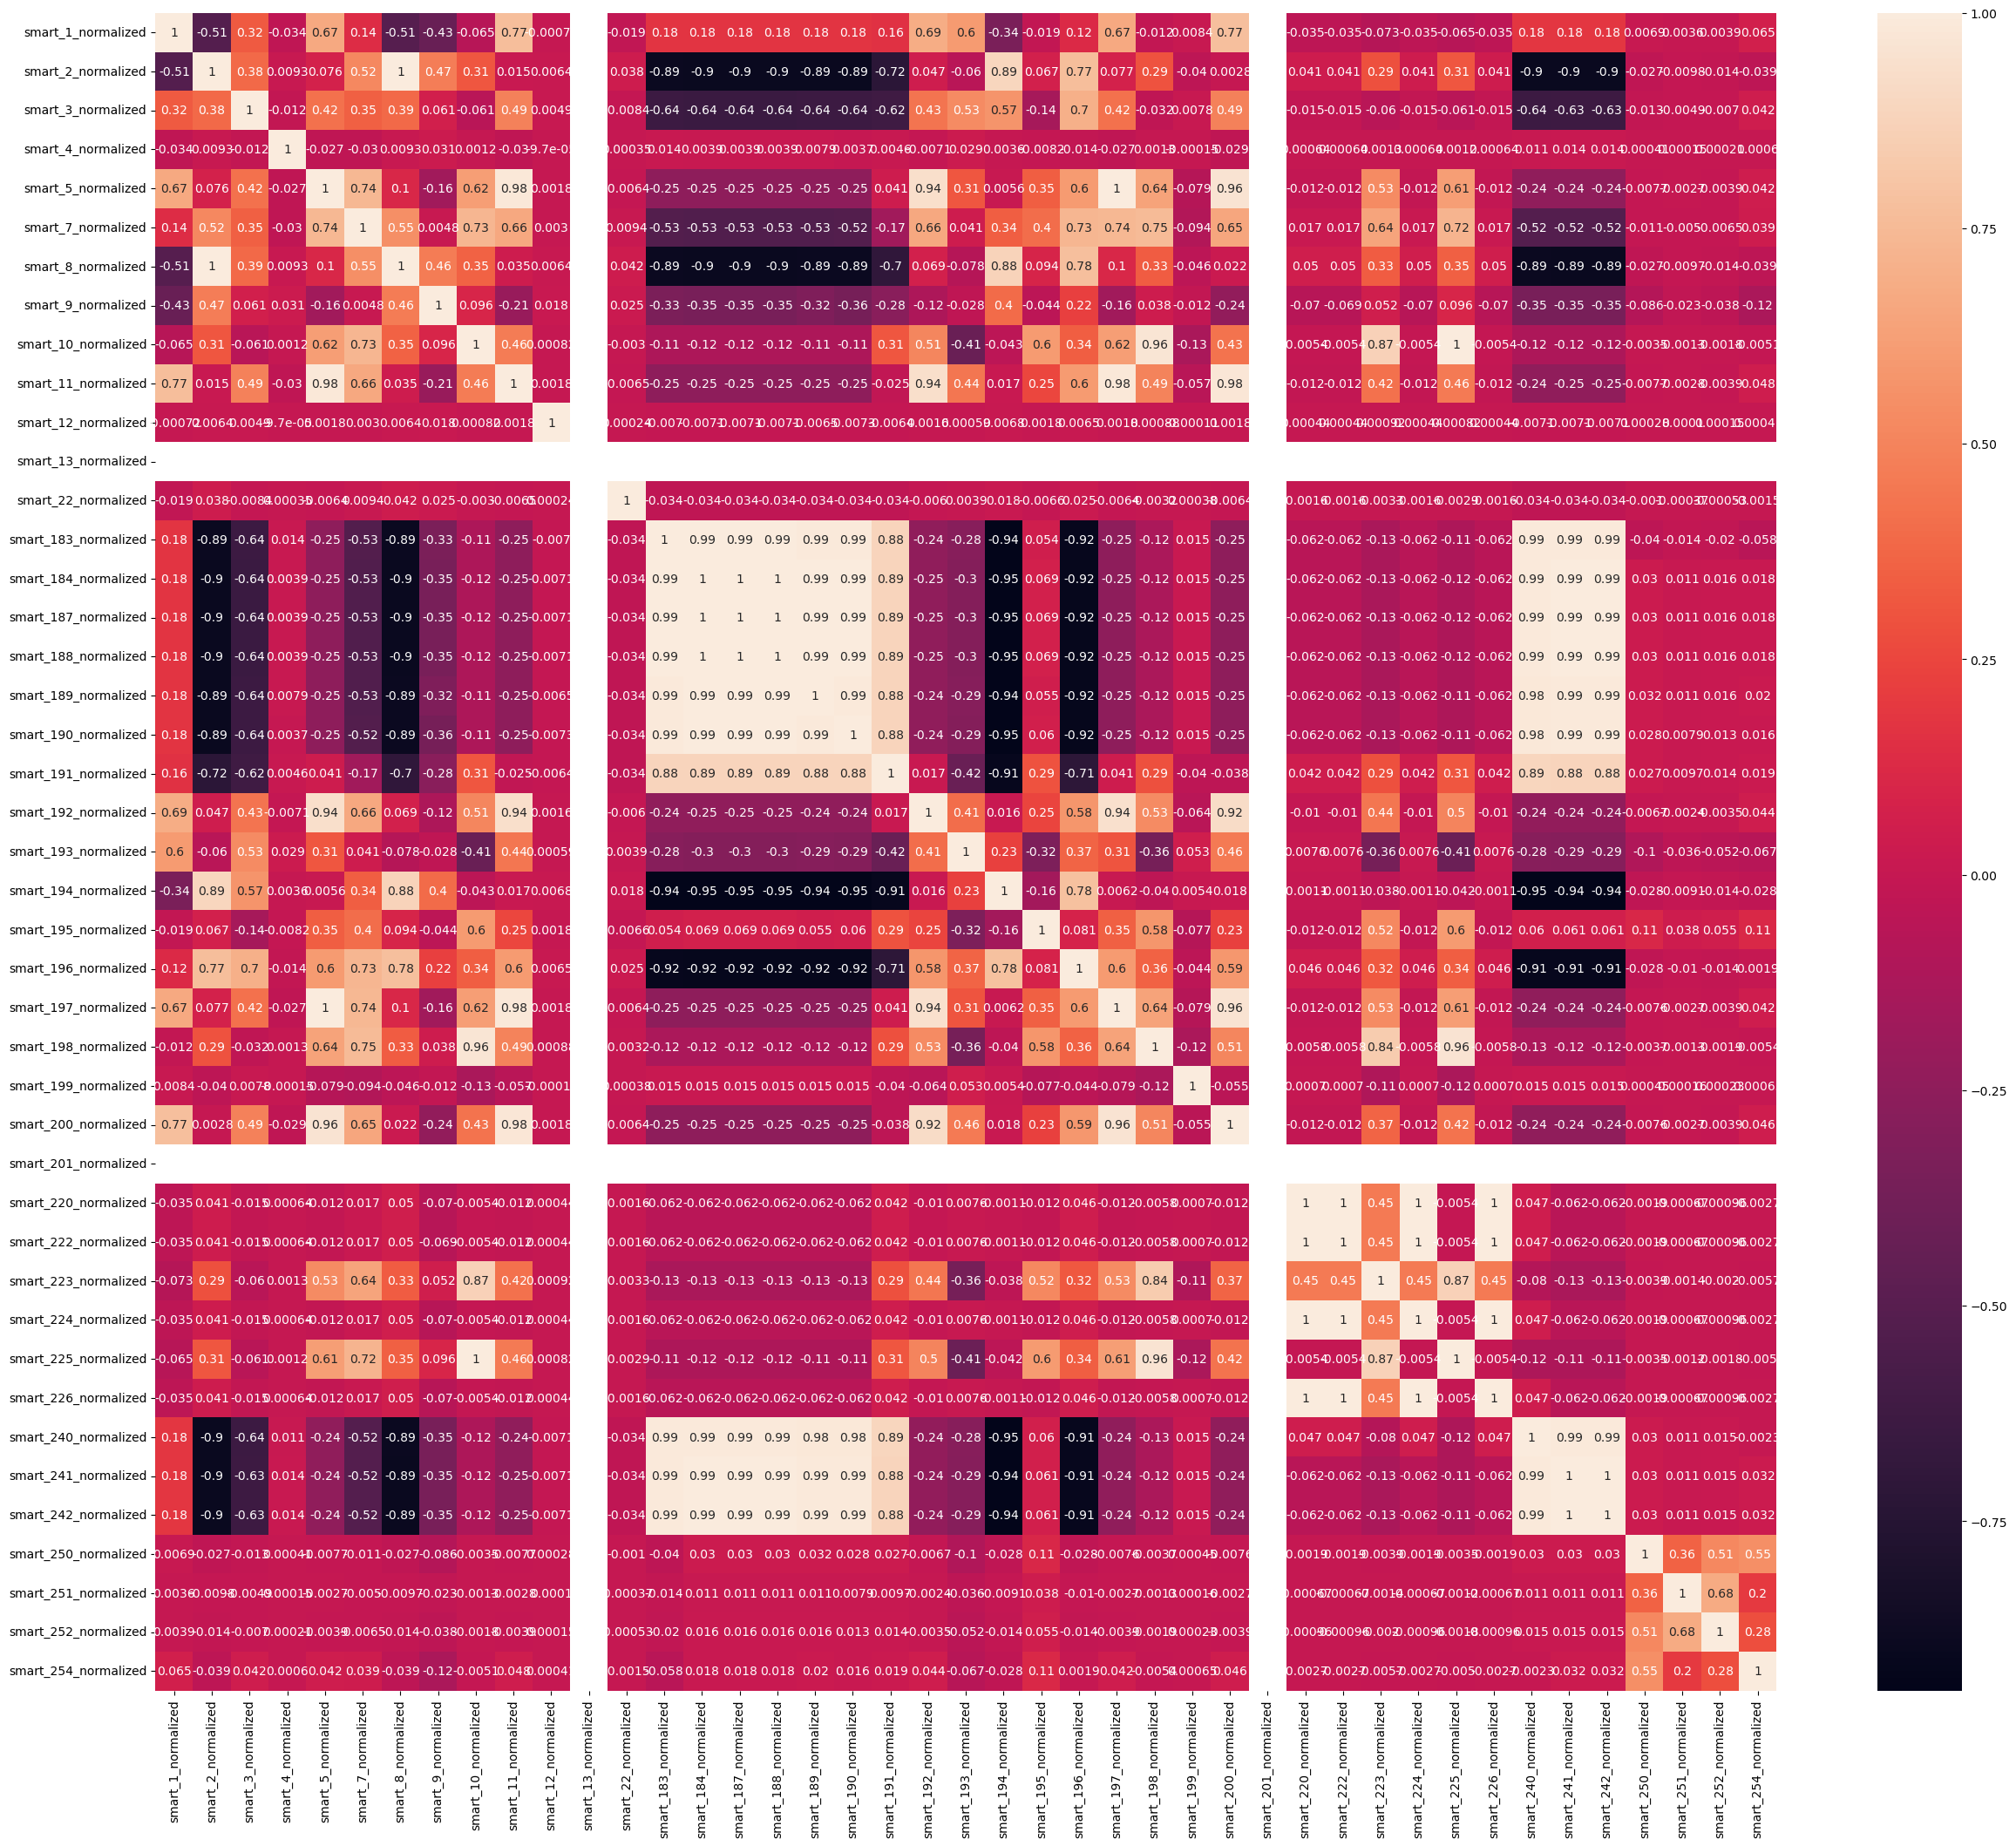

In [33]:
plt.figure(figsize=(30, 25)) 
sns.heatmap(df.corr(), annot=True)
plt.show()

In [34]:
columns_to_plot = df.columns
columns_to_plot=list(columns_to_plot)
columns_to_plot

['smart_1_normalized',
 'smart_2_normalized',
 'smart_3_normalized',
 'smart_4_normalized',
 'smart_5_normalized',
 'smart_7_normalized',
 'smart_8_normalized',
 'smart_9_normalized',
 'smart_10_normalized',
 'smart_11_normalized',
 'smart_12_normalized',
 'smart_13_normalized',
 'smart_22_normalized',
 'smart_183_normalized',
 'smart_184_normalized',
 'smart_187_normalized',
 'smart_188_normalized',
 'smart_189_normalized',
 'smart_190_normalized',
 'smart_191_normalized',
 'smart_192_normalized',
 'smart_193_normalized',
 'smart_194_normalized',
 'smart_195_normalized',
 'smart_196_normalized',
 'smart_197_normalized',
 'smart_198_normalized',
 'smart_199_normalized',
 'smart_200_normalized',
 'smart_201_normalized',
 'smart_220_normalized',
 'smart_222_normalized',
 'smart_223_normalized',
 'smart_224_normalized',
 'smart_225_normalized',
 'smart_226_normalized',
 'smart_240_normalized',
 'smart_241_normalized',
 'smart_242_normalized',
 'smart_250_normalized',
 'smart_251_normalize

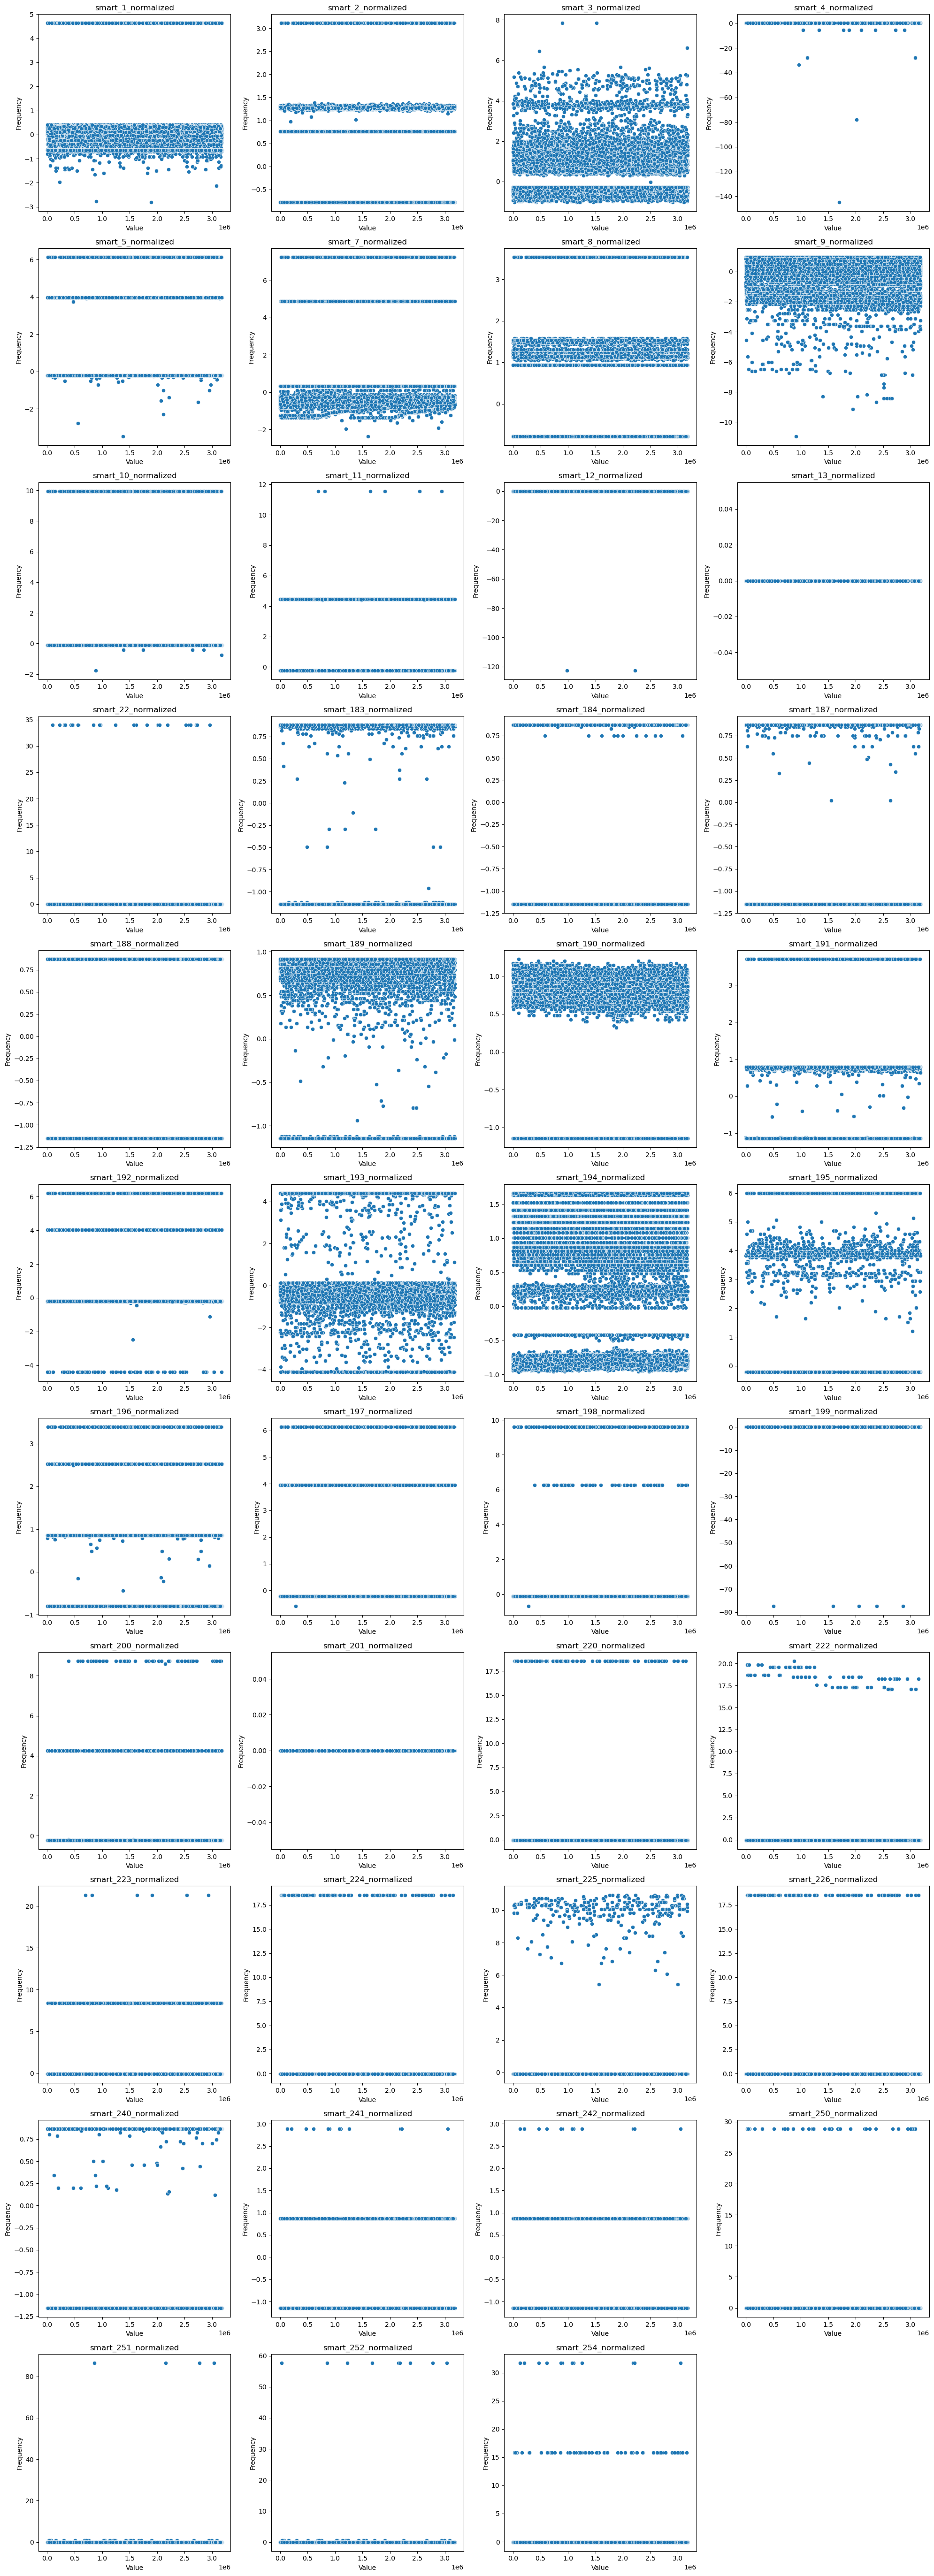

In [35]:
num_cols = 4
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols 
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
axs = axs.flatten()


for i, column in enumerate(columns_to_plot):
    sns.scatterplot(df[column], ax=axs[i])
    axs[i].set_title(column)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')


for j in range(len(columns_to_plot), num_cols*num_rows):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [37]:
X_train, X_val = train_test_split(df, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(df, test_size=0.5, random_state=42)

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 1356707 to 48939
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   smart_1_normalized    21000 non-null  float64
 1   smart_2_normalized    21000 non-null  float64
 2   smart_3_normalized    21000 non-null  float64
 3   smart_4_normalized    21000 non-null  float64
 4   smart_5_normalized    21000 non-null  float64
 5   smart_7_normalized    21000 non-null  float64
 6   smart_8_normalized    21000 non-null  float64
 7   smart_9_normalized    21000 non-null  float64
 8   smart_10_normalized   21000 non-null  float64
 9   smart_11_normalized   21000 non-null  float64
 10  smart_12_normalized   21000 non-null  float64
 11  smart_13_normalized   21000 non-null  float64
 12  smart_22_normalized   21000 non-null  float64
 13  smart_183_normalized  21000 non-null  float64
 14  smart_184_normalized  21000 non-null  float64
 15  smart_187_normaliz

In [39]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [40]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [41]:
X_train = DataLoader(X_train_tensor,batch_size=32,shuffle=True)
X_val = DataLoader(X_val_tensor,batch_size=32,shuffle=False)
X_test = DataLoader(X_test_tensor,batch_size=32,shuffle=False)

In [122]:
X_train_tensor.shape

torch.Size([21000, 43])

In [123]:
X_val_tensor.shape

torch.Size([15000, 43])

In [124]:
X_test_tensor.shape

torch.Size([15000, 43])

In [111]:
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size) 
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [112]:
X_train_tensor.shape[1]

43

In [113]:
input_dim = X_train_tensor.shape[1]
encoding_dim = 32
num_epochs = 20
batch_size = 64
learning_rate = 0.01


train_loader = DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(X_val_tensor, batch_size=batch_size, shuffle=False)

In [114]:
autoencoder_model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model.parameters(), lr=learning_rate)

In [115]:
autoencoder_model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=43, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=43, bias=True)
  )
)

In [116]:
from tqdm.auto import tqdm

In [117]:
autoencoder_train_loss, autoencoder_val_loss = [],[]
autoencoder_train_r2_loss, autoencoder_val_r2_loss = [],[]

for epoch in range(num_epochs):
    running_loss = 0.0
    autoencoder_model.train()
    for train_inputs in tqdm(train_loader):
        optimizer.zero_grad()
        train_inputs= train_inputs.to(device)
        train_outputs = autoencoder_model(train_inputs)
        loss = criterion(train_outputs, train_inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_loader)}")
    autoencoder_train_loss.append(running_loss / len(train_loader))
    autoencoder_train_r2_loss.append(r2_score(train_outputs.detach().cpu().numpy(), train_inputs.detach().cpu().numpy()))
    
    
    autoencoder_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs in val_loader:
            val_inputs= val_inputs.to(device)
            val_outputs = autoencoder_model(val_inputs)
            val_loss += loss.item()
            torch.cuda.empty_cache()
        
        gc.collect()
    avg_val_loss = val_loss / len(val_loader)
    autoencoder_val_loss.append(avg_val_loss)
    autoencoder_val_r2_loss.append(r2_score(val_outputs.detach().cpu().numpy(), val_inputs.detach().cpu().numpy()))
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {(running_loss / len(train_loader)):.2f}, Val Loss: {avg_val_loss:2f}")


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.33715074901443576
Epoch [1/20], Train Loss: 0.34, Val Loss: 0.010129


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.2516871029893248
Epoch [2/20], Train Loss: 0.25, Val Loss: 0.013090


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.20185671680207765
Epoch [3/20], Train Loss: 0.20, Val Loss: 0.006230


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.20440899986083022
Epoch [4/20], Train Loss: 0.20, Val Loss: 0.011830


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.24061394839810835
Epoch [5/20], Train Loss: 0.24, Val Loss: 0.005422


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.16767901033983992
Epoch [6/20], Train Loss: 0.17, Val Loss: 0.166376


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.17442040652953836
Epoch [7/20], Train Loss: 0.17, Val Loss: 0.048443


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.17731315900053612
Epoch [8/20], Train Loss: 0.18, Val Loss: 1.135106


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.15268076299817096
Epoch [9/20], Train Loss: 0.15, Val Loss: 0.003155


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.1584699383574484
Epoch [10/20], Train Loss: 0.16, Val Loss: 0.018789


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.17527261673045375
Epoch [11/20], Train Loss: 0.18, Val Loss: 0.058170


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.16914921132550437
Epoch [12/20], Train Loss: 0.17, Val Loss: 0.004168


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.17694600876194275
Epoch [13/20], Train Loss: 0.18, Val Loss: 0.006059


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.15718030831196253
Epoch [14/20], Train Loss: 0.16, Val Loss: 0.004360


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.16471231784275236
Epoch [15/20], Train Loss: 0.16, Val Loss: 0.078311


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.21500617486359636
Epoch [16/20], Train Loss: 0.22, Val Loss: 0.005744


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.22581203606426942
Epoch [17/20], Train Loss: 0.23, Val Loss: 0.005341


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.23256325265279432
Epoch [18/20], Train Loss: 0.23, Val Loss: 0.004035


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.19330064076533976
Epoch [19/20], Train Loss: 0.19, Val Loss: 0.005373


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.16648104537906844
Epoch [20/20], Train Loss: 0.17, Val Loss: 0.002819


In [118]:
autoencoder_model.eval()
with torch.no_grad():
    X_reconstructed = autoencoder_model(X_test_tensor.to(device))
    test_loss = criterion(X_reconstructed, X_test_tensor.to(device))
    print(f"Test Loss: {test_loss.item() :.2f}")

Test Loss: 0.15


In [50]:
threshold = 0.5
anomalies = torch.abs(X_reconstructed.to(device) - X_test_tensor.to(device)) > threshold
print(f"Number of anomalies: {anomalies.sum()}")
anomalies_indices = torch.where(X_reconstructed.to(device) - X_test_tensor.to(device) > threshold)[0]
print("Anomalies' Indices:")
print(anomalies_indices)

Number of anomalies: 9916
Anomalies' Indices:
tensor([14985,     7,     9,  ..., 14998, 14998, 14998], device='mps:0')


In [51]:
torch.save(autoencoder_model.state_dict(), 'autoencoder_model_base.pth')

In [52]:
summary(autoencoder_model)

Layer (type:depth-idx)                   Param #
Autoencoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       2,816
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       2,080
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       528
│    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
│    └─Linear: 2-7                       544
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       2,112
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      2,795
Total params: 10,875
Trainable params: 10,875
Non-trainable params: 0

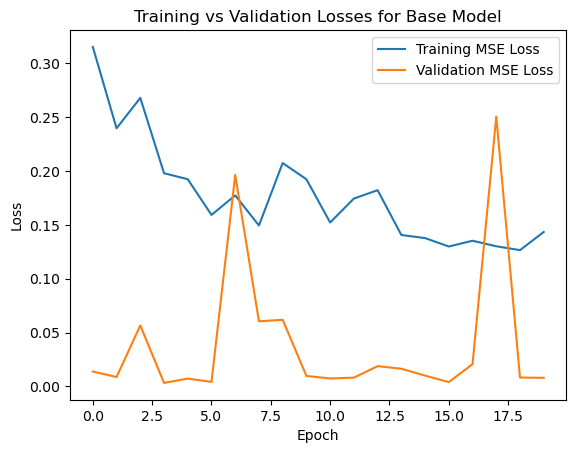

In [53]:
plt.plot(autoencoder_train_loss, label='Training MSE Loss')
plt.plot(autoencoder_val_loss, label='Validation MSE Loss')
plt.title('Training vs Validation Losses for Base Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

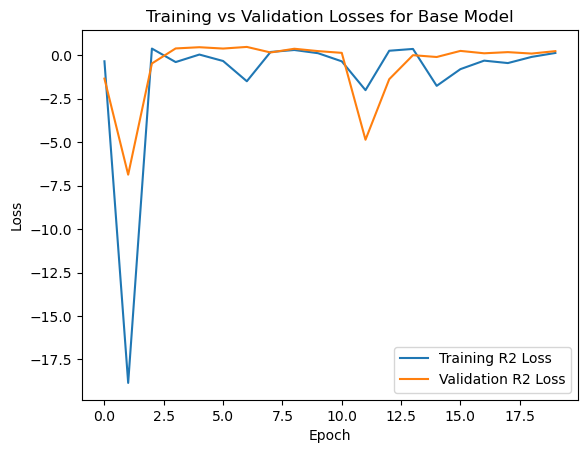

In [54]:
plt.plot(autoencoder_train_r2_loss, label='Training R2 Loss')
plt.plot(autoencoder_val_r2_loss, label='Validation R2 Loss')
plt.title('Training vs Validation Losses for Base Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model 2 - Enhancement1

- Added a Dense Layer

In [55]:
input_dim = X_train_tensor.shape[1]
encoding_dim = 32
num_epochs = 20
batch_size = 64
learning_rate = 0.01


train_loader = DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(X_val_tensor, batch_size=batch_size, shuffle=False)

In [56]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64), 
            nn.ReLU(True),
            nn.Linear(64, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),  
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [57]:
X_train_tensor.shape[1]

43

In [58]:
input_dim = X_train_tensor.shape[1]
encoding_dim = 32
num_epochs = 20
batch_size = 64
learning_rate = 0.01


train_loader = DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(X_val_tensor, batch_size=batch_size, shuffle=False)

In [59]:
autoencoder_model_one = Autoencoder(input_dim,encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model_one.parameters(), lr=learning_rate)

In [60]:
autoencoder_model_one.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=43, bias=True)
  )
)

In [62]:
autoencoder_train_loss_one, autoencoder_val_loss_one = [],[]
autoencoder_train_r2_loss_one, autoencoder_val_r2_loss_one = [],[]

for epoch in range(num_epochs):
    running_loss = 0.0
    autoencoder_model_one.train()
    for train_inputs in tqdm(train_loader):
        optimizer.zero_grad()
        train_inputs= train_inputs.to(device)
        train_outputs = autoencoder_model_one(train_inputs)
        loss = criterion(train_outputs, train_inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() #*  train_inputs.size(0)
        #del inputs
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_loader)}")
    autoencoder_train_loss_one.append(running_loss / len(train_loader))
    autoencoder_train_r2_loss_one.append(r2_score(train_outputs.detach().cpu().numpy(), train_inputs.detach().cpu().numpy()))
    
    
    autoencoder_model_one.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in val_loader:
            inputs= inputs.to(device)
            outputs = autoencoder_model_one(inputs)
            val_loss += loss.item()
            #del inputs
            torch.cuda.empty_cache()
        gc.collect()
    avg_val_loss = val_loss / len(val_loader)
    autoencoder_val_loss_one.append(avg_val_loss)
    autoencoder_val_r2_loss_one.append(r2_score(val_outputs.detach().cpu().numpy(), val_inputs.detach().cpu().numpy()))
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {(running_loss / len(train_loader)):.2f}, Val Loss: {avg_val_loss:.2f}")


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.2757520903521826
Epoch [1/20], Train Loss: 0.28, Val Loss: 0.01


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.22969524368168193
Epoch [2/20], Train Loss: 0.23, Val Loss: 0.02


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.2997873963287106
Epoch [3/20], Train Loss: 0.30, Val Loss: 0.10


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.32964969903660946
Epoch [4/20], Train Loss: 0.33, Val Loss: 0.02


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.35190659832198024
Epoch [5/20], Train Loss: 0.35, Val Loss: 0.26


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.3472736674420377
Epoch [6/20], Train Loss: 0.35, Val Loss: 0.05


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.33851927044407937
Epoch [7/20], Train Loss: 0.34, Val Loss: 0.10


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 2.059083566748987
Epoch [8/20], Train Loss: 2.06, Val Loss: 0.38


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.9399014918818662
Epoch [9/20], Train Loss: 0.94, Val Loss: 0.36


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.9398922970048562
Epoch [10/20], Train Loss: 0.94, Val Loss: 0.37


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.9451392882681907
Epoch [11/20], Train Loss: 0.95, Val Loss: 2.28


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.939954374789467
Epoch [12/20], Train Loss: 0.94, Val Loss: 0.38


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.941240884159836
Epoch [13/20], Train Loss: 0.94, Val Loss: 0.85


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.9400889093571521
Epoch [14/20], Train Loss: 0.94, Val Loss: 0.38


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.940703926930674
Epoch [15/20], Train Loss: 0.94, Val Loss: 0.60


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.9396962944678623
Epoch [16/20], Train Loss: 0.94, Val Loss: 0.27


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.9400971990225888
Epoch [17/20], Train Loss: 0.94, Val Loss: 0.38


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.9411728626688926
Epoch [18/20], Train Loss: 0.94, Val Loss: 0.79


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.9491644123948454
Epoch [19/20], Train Loss: 0.95, Val Loss: 3.81


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.9402010468907631
Epoch [20/20], Train Loss: 0.94, Val Loss: 0.35


In [63]:
autoencoder_model_one.eval()
with torch.no_grad():
    X_reconstructed_one = autoencoder_model_one(X_test_tensor.to(device))
    test_loss = criterion(X_reconstructed_one.to(device), X_test_tensor.to(device))
    print(f"Test Loss: {test_loss.item():2f}")


Test Loss: 0.953724


In [64]:
torch.save(autoencoder_model_one.state_dict(), 'autoencoder_model_one.pth')

In [65]:
threshold = 0.5
anomalies = torch.abs(X_reconstructed_one.to(device) - X_test_tensor.to(device)) > threshold
print(f"Number of anomalies: {anomalies.sum()}")
anomalies_indices = torch.where(X_reconstructed_one.to(device) - X_test_tensor.to(device) > threshold)[0]
print("Anomalies' Indices:")
print(anomalies_indices)

Number of anomalies: 247128
Anomalies' Indices:
tensor([14996,     0,     0,  ..., 14999, 14999, 14999], device='mps:0')


In [66]:
summary(autoencoder_model_one)

Layer (type:depth-idx)                   Param #
Autoencoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       5,632
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       8,256
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       2,080
├─Sequential: 1-2                        --
│    └─Linear: 2-6                       2,112
│    └─ReLU: 2-7                         --
│    └─Linear: 2-8                       8,320
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      5,547
Total params: 31,947
Trainable params: 31,947
Non-trainable params: 0

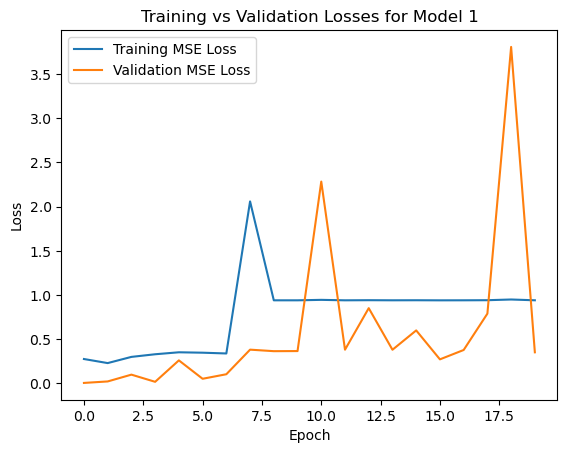

In [67]:
plt.plot(autoencoder_train_loss_one, label='Training MSE Loss')
plt.plot(autoencoder_val_loss_one, label='Validation MSE Loss')
plt.title('Training vs Validation Losses for Model 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

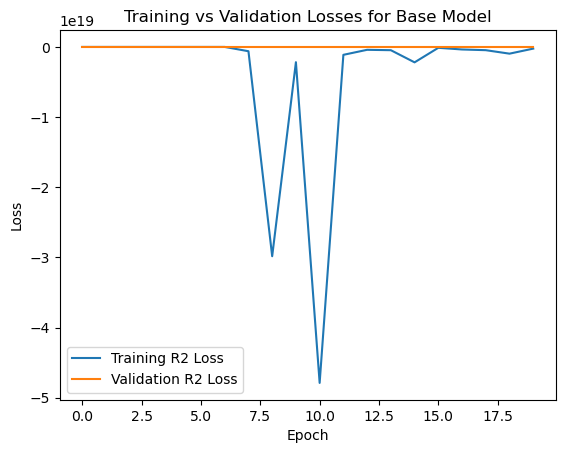

In [69]:
plt.plot(autoencoder_train_r2_loss_one, label='Training R2 Loss')
plt.plot(autoencoder_val_r2_loss_one, label='Validation R2 Loss')
plt.title('Training vs Validation Losses for Base Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model 3 - Enhancement2
- Added a Dense Layer +  Tanh Activation Function

In [70]:
input_dim = X_train_tensor.shape[1]
encoding_dim = 32
num_epochs = 20
batch_size = 64
learning_rate = 0.01


train_loader = DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(X_val_tensor, batch_size=batch_size, shuffle=False)

In [71]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(), 
            nn.Linear(128, 64),
            nn.Tanh(),  
            nn.Linear(64, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.Tanh(), 
            nn.Linear(64, 128),
            nn.Tanh(), 
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [72]:
autoencoder_model_two = Autoencoder(input_dim,encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model_two.parameters(), lr=learning_rate)

In [73]:
autoencoder_model_two.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=43, bias=True)
  )
)

In [74]:
autoencoder_train_loss_two, autoencoder_val_loss_two = [],[]
autoencoder_train_r2_loss_two, autoencoder_val_r2_loss_two = [],[]

for epoch in range(num_epochs):
    running_loss = 0.0
    autoencoder_model_two.train()
    for train_inputs in tqdm(train_loader):
        optimizer.zero_grad()
        train_inputs= train_inputs.to(device)
        train_outputs = autoencoder_model_two(train_inputs)
        loss = criterion(train_outputs, train_inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() #*  train_inputs.size(0)
        #del inputs
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    autoencoder_train_loss_two.append(running_loss / len(train_loader))
    autoencoder_train_r2_loss_two.append(r2_score(train_outputs.detach().cpu().numpy(), train_inputs.detach().cpu().numpy()))
    
    autoencoder_model_two.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in val_loader:
            inputs= inputs.to(device)
            outputs = autoencoder_model_two(inputs)
            val_loss += loss.item()
            #del inputs
            torch.cuda.empty_cache()
        gc.collect()
    avg_val_loss = val_loss / len(val_loader)
    autoencoder_val_loss_two.append(avg_val_loss)
    autoencoder_val_r2_loss_two.append(r2_score(val_outputs.detach().cpu().numpy(), val_inputs.detach().cpu().numpy()))
    
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {(running_loss / len(train_loader)):.2f}, Val Loss: {avg_val_loss:.2f}")


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.2536526832525763
Epoch [1/20], Train Loss: 0.25, Val Loss: 0.00


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [2/20], Loss: 0.15369661141039753
Epoch [2/20], Train Loss: 0.15, Val Loss: 0.02


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [3/20], Loss: 0.1475170308732538
Epoch [3/20], Train Loss: 0.15, Val Loss: 0.01


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [4/20], Loss: 0.12433223367886657
Epoch [4/20], Train Loss: 0.12, Val Loss: 0.00


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.10392033611070421
Epoch [5/20], Train Loss: 0.10, Val Loss: 0.00


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [6/20], Loss: 0.09891491269941886
Epoch [6/20], Train Loss: 0.10, Val Loss: 0.01


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [7/20], Loss: 0.16991407821934365
Epoch [7/20], Train Loss: 0.17, Val Loss: 0.02


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [8/20], Loss: 0.12194278479007421
Epoch [8/20], Train Loss: 0.12, Val Loss: 0.13


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [9/20], Loss: 0.11646892525267002
Epoch [9/20], Train Loss: 0.12, Val Loss: 0.15


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [10/20], Loss: 0.12032683027234484
Epoch [10/20], Train Loss: 0.12, Val Loss: 0.07


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [11/20], Loss: 0.1030791845642551
Epoch [11/20], Train Loss: 0.10, Val Loss: 0.07


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [12/20], Loss: 0.10094791782402793
Epoch [12/20], Train Loss: 0.10, Val Loss: 0.09


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [13/20], Loss: 0.09627686474206192
Epoch [13/20], Train Loss: 0.10, Val Loss: 0.01


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [14/20], Loss: 0.09096038394316035
Epoch [14/20], Train Loss: 0.09, Val Loss: 0.00


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [15/20], Loss: 0.08548451395065589
Epoch [15/20], Train Loss: 0.09, Val Loss: 0.16


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [16/20], Loss: 0.08204257212533958
Epoch [16/20], Train Loss: 0.08, Val Loss: 0.01


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [17/20], Loss: 0.12328693633870785
Epoch [17/20], Train Loss: 0.12, Val Loss: 0.03


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [18/20], Loss: 0.2732108310714228
Epoch [18/20], Train Loss: 0.27, Val Loss: 0.21


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [19/20], Loss: 0.182365981227857
Epoch [19/20], Train Loss: 0.18, Val Loss: 0.05


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [20/20], Loss: 0.16721465757914952
Epoch [20/20], Train Loss: 0.17, Val Loss: 0.08


In [75]:
autoencoder_model_two.eval()
with torch.no_grad():
    X_reconstructed_two = autoencoder_model_two(X_test_tensor.to(device))
    test_loss = criterion(X_reconstructed_two.to(device), X_test_tensor.to(device))
    print(f"Test Loss: {test_loss.item():3f}")

Test Loss: 0.145470


In [76]:
torch.save(autoencoder_model_two.state_dict(), 'autoencoder_model_two.pth')

In [77]:
threshold = 0.5
anomalies = torch.abs(X_reconstructed_two.to(device) - X_test_tensor.to(device)) > threshold
print(f"Number of anomalies: {anomalies.sum()}")
anomalies_indices = torch.where(X_reconstructed_two.to(device) - X_test_tensor.to(device) > threshold)[0]
print("Anomalies' Indices:")
print(anomalies_indices)

Number of anomalies: 17958
Anomalies' Indices:
tensor([14997,     2,     3,  ..., 14996, 14996, 14997], device='mps:0')


In [78]:
summary(autoencoder_model_two)

Layer (type:depth-idx)                   Param #
Autoencoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       5,632
│    └─Tanh: 2-2                         --
│    └─Linear: 2-3                       8,256
│    └─Tanh: 2-4                         --
│    └─Linear: 2-5                       2,080
├─Sequential: 1-2                        --
│    └─Linear: 2-6                       2,112
│    └─Tanh: 2-7                         --
│    └─Linear: 2-8                       8,320
│    └─Tanh: 2-9                         --
│    └─Linear: 2-10                      5,547
Total params: 31,947
Trainable params: 31,947
Non-trainable params: 0

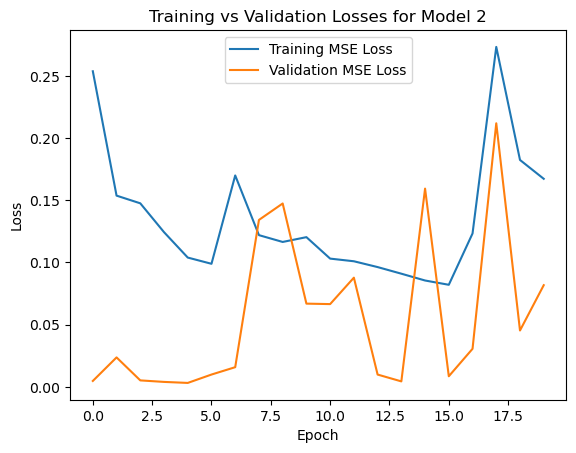

In [79]:
plt.plot(autoencoder_train_loss_two, label='Training MSE Loss')
plt.plot(autoencoder_val_loss_two, label='Validation MSE Loss')
plt.title('Training vs Validation Losses for Model 2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

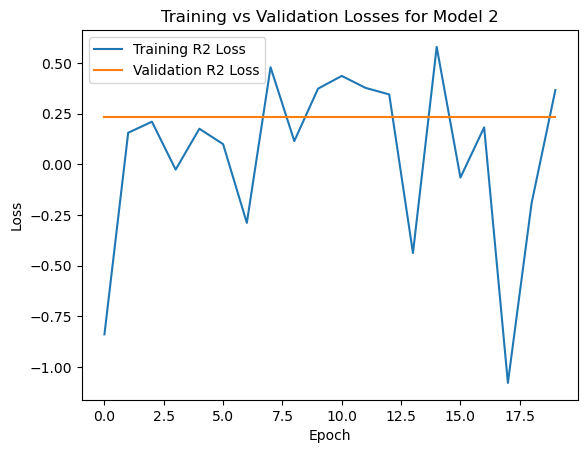

In [107]:
plt.plot(autoencoder_train_r2_loss_two, label='Training R2 Loss')
plt.plot(autoencoder_val_r2_loss_two, label='Validation R2 Loss')
plt.title('Training vs Validation Losses for Model 2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model 4 - Enhancement3
- Added a Dense Layer +  Tanh Activation Function + Dropout

In [81]:
input_dim = X_train_tensor.shape[1]
encoding_dim = 32
num_epochs = 20
batch_size = 64
learning_rate = 0.01


train_loader = DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(X_val_tensor, batch_size=batch_size, shuffle=False)

In [82]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Dropout(0.2),  
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Dropout(0.2),  
            nn.Linear(64, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.Tanh(),
            nn.Dropout(0.2),  
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Dropout(0.2), 
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [83]:
autoencoder_model_three = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model_three.parameters(), lr=learning_rate)

In [84]:
autoencoder_model_three.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=43, bias=True)
  )
)

In [87]:
autoencoder_train_loss_three, autoencoder_val_loss_three = [],[]
autoencoder_train_r2_loss_three, autoencoder_val_r2_loss_three = [],[]

for epoch in range(num_epochs):
    running_loss = 0.0
    autoencoder_model_three.train()
    for train_inputs in tqdm(train_loader):
        optimizer.zero_grad()
        train_inputs= train_inputs.to(device)
        train_outputs = autoencoder_model_three(train_inputs)
        loss = criterion(train_outputs, train_inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() #*  inputs.size(0)
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    autoencoder_train_loss_three.append(running_loss / len(train_loader))
    autoencoder_train_r2_loss_three.append(r2_score(train_outputs.detach().cpu().numpy(), train_inputs.detach().cpu().numpy()))
    
    autoencoder_model_three.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs in val_loader:
            val_inputs= val_inputs.to(device)
            val_outputs = autoencoder_model_three(val_inputs)
            val_loss += loss.item()
            torch.cuda.empty_cache()
        gc.collect()
    avg_val_loss = val_loss / len(val_loader)
    autoencoder_val_loss_three.append(avg_val_loss)
    autoencoder_val_r2_loss_three.append(r2_score(val_outputs.detach().cpu().numpy(), val_inputs.detach().cpu().numpy()))
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {(running_loss / len(train_loader)):.2f}, Val Loss: {avg_val_loss:.2f}")


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.22130462906031803
Epoch [1/20], Train Loss: 0.22, Val Loss: 0.04


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [2/20], Loss: 0.18896584594225946
Epoch [2/20], Train Loss: 0.19, Val Loss: 0.01


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [3/20], Loss: 0.1884709846534084
Epoch [3/20], Train Loss: 0.19, Val Loss: 0.01


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [4/20], Loss: 0.1923669726222663
Epoch [4/20], Train Loss: 0.19, Val Loss: 0.02


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.1936912420814387
Epoch [5/20], Train Loss: 0.19, Val Loss: 0.05


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [6/20], Loss: 0.18332717436900797
Epoch [6/20], Train Loss: 0.18, Val Loss: 0.08


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [7/20], Loss: 0.168693063097035
Epoch [7/20], Train Loss: 0.17, Val Loss: 0.04


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [8/20], Loss: 0.23375448570968896
Epoch [8/20], Train Loss: 0.23, Val Loss: 0.01


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [9/20], Loss: 0.16563280284444384
Epoch [9/20], Train Loss: 0.17, Val Loss: 0.02


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [10/20], Loss: 0.18959102693288432
Epoch [10/20], Train Loss: 0.19, Val Loss: 0.02


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [11/20], Loss: 0.22216674524690605
Epoch [11/20], Train Loss: 0.22, Val Loss: 0.05


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [12/20], Loss: 0.21262388783124894
Epoch [12/20], Train Loss: 0.21, Val Loss: 0.04


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [13/20], Loss: 0.19118273601156735
Epoch [13/20], Train Loss: 0.19, Val Loss: 0.01


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [14/20], Loss: 0.1695442575760367
Epoch [14/20], Train Loss: 0.17, Val Loss: 0.02


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [15/20], Loss: 0.21386148128658533
Epoch [15/20], Train Loss: 0.21, Val Loss: 0.05


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [16/20], Loss: 0.19858623067579462
Epoch [16/20], Train Loss: 0.20, Val Loss: 0.12


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [17/20], Loss: 0.21695254763763816
Epoch [17/20], Train Loss: 0.22, Val Loss: 0.01


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [18/20], Loss: 0.19920943945782163
Epoch [18/20], Train Loss: 0.20, Val Loss: 0.03


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [19/20], Loss: 0.19555339374010505
Epoch [19/20], Train Loss: 0.20, Val Loss: 0.02


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [20/20], Loss: 0.20720853495742775
Epoch [20/20], Train Loss: 0.21, Val Loss: 0.03


In [88]:
autoencoder_model_three.eval()
with torch.no_grad():
    X_reconstructed_three = autoencoder_model_three(X_test_tensor.to(device))
    test_loss = criterion(X_reconstructed_three.to(device), X_test_tensor.to(device))
    print(f"Test Loss: {test_loss.item():3f}")

Test Loss: 0.192079


In [89]:
torch.save(autoencoder_model_three.state_dict(), 'autoencoder_model_three.pth')

In [90]:
threshold = 0.5
anomalies = torch.abs(X_reconstructed_three.to(device) - X_test_tensor.to(device)) > threshold
print(f"Number of anomalies: {anomalies.sum()}")
anomalies_indices = torch.where(X_reconstructed_three.to(device) - X_test_tensor.to(device) > threshold)[0]
print("Anomalies' Indices:")
print(anomalies_indices)

Number of anomalies: 22222
Anomalies' Indices:
tensor([14995,    10,    13,  ..., 14991, 14991, 14998], device='mps:0')


In [91]:
summary(autoencoder_model_three)

Layer (type:depth-idx)                   Param #
Autoencoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       5,632
│    └─Tanh: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       8,256
│    └─Tanh: 2-5                         --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       2,080
├─Sequential: 1-2                        --
│    └─Linear: 2-8                       2,112
│    └─Tanh: 2-9                         --
│    └─Dropout: 2-10                     --
│    └─Linear: 2-11                      8,320
│    └─Tanh: 2-12                        --
│    └─Dropout: 2-13                     --
│    └─Linear: 2-14                      5,547
Total params: 31,947
Trainable params: 31,947
Non-trainable params: 0

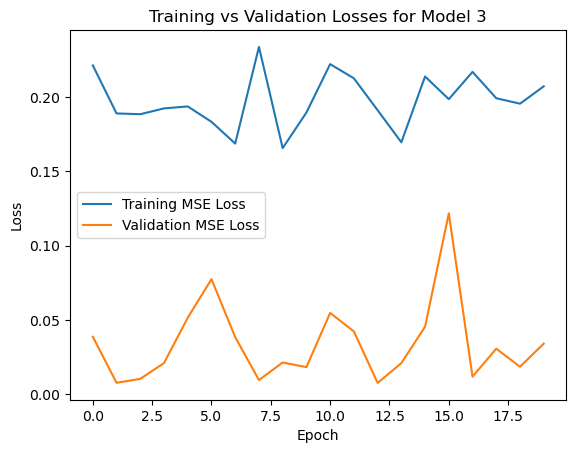

In [92]:
plt.plot(autoencoder_train_loss_three, label='Training MSE Loss')
plt.plot(autoencoder_val_loss_three, label='Validation MSE Loss')
plt.title('Training vs Validation Losses for Model 3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

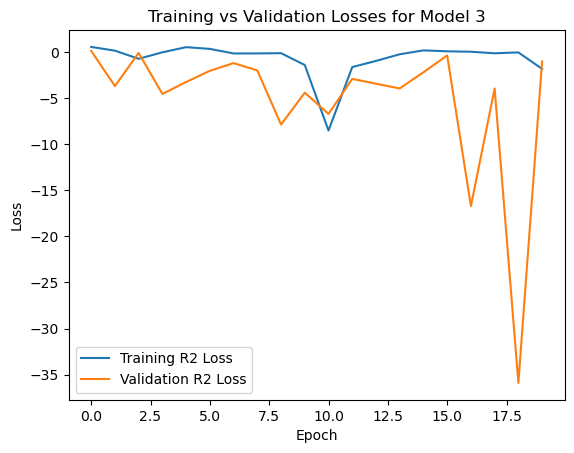

In [106]:
plt.plot(autoencoder_train_r2_loss_three, label='Training R2 Loss')
plt.plot(autoencoder_val_r2_loss_three, label='Validation R2 Loss')
plt.title('Training vs Validation Losses for Model 3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model 5 - Enhancement4
Added a Dense Layer + Tanh Activation Function + Dropout + Early Stopping

In [93]:
input_dim = X_train_tensor.shape[1]
encoding_dim = 32
num_epochs = 20
batch_size = 64
learning_rate = 0.01


train_loader = DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(X_val_tensor, batch_size=batch_size, shuffle=False)

In [94]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Dropout(0.2),  
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Dropout(0.2),  
            nn.Linear(64, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.Tanh(),
            nn.Dropout(0.2),  
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Dropout(0.2), 
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [95]:
autoencoder_model_four = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model_four.parameters(), lr=learning_rate)

In [96]:
autoencoder_model_four.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=43, bias=True)
  )
)

In [97]:
autoencoder_train_loss_four, autoencoder_val_loss_four = [],[]
autoencoder_train_r2_loss_four, autoencoder_val_r2_loss_four = [],[]

min_val_loss = float('inf')
patience = 5 
early_stopping_counter = 0

for epoch in range(num_epochs):
    running_loss = 0.0
    autoencoder_model_four.train()
    for inputs in tqdm(train_loader):
        optimizer.zero_grad()
        inputs= inputs.to(device)
        outputs = autoencoder_model_four(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() #*  inputs.size(0)
        #del inputs
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    autoencoder_train_loss_four.append(running_loss / len(train_loader))
    autoencoder_train_r2_loss_four.append(r2_score(outputs.detach().cpu().numpy(), inputs.detach().cpu().numpy()))
    
    
    autoencoder_model_four.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in val_loader:
            inputs= inputs.to(device)
            outputs = autoencoder_model_four(inputs)
            val_loss += loss.item()
            #del inputs
            torch.cuda.empty_cache()
        gc.collect()
    avg_val_loss = val_loss / len(val_loader)
    autoencoder_val_r2_loss_four.append(r2_score(outputs.detach().cpu().numpy(), inputs.detach().cpu().numpy()))
    autoencoder_val_loss_four.append(avg_val_loss)
    
    
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {(running_loss / len(train_loader)):.2f}, Val Loss: {(avg_val_loss):.2f}")


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.30835504093034743
Epoch [1/20], Train Loss: 0.31, Val Loss: 0.01


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [2/20], Loss: 0.21788699967690422
Epoch [2/20], Train Loss: 0.22, Val Loss: 0.05


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [3/20], Loss: 0.18782165997143618
Epoch [3/20], Train Loss: 0.19, Val Loss: 0.04


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [4/20], Loss: 0.2248664342184016
Epoch [4/20], Train Loss: 0.22, Val Loss: 0.02


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.17978101860205317
Epoch [5/20], Train Loss: 0.18, Val Loss: 0.01


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [6/20], Loss: 0.20304752802363057
Epoch [6/20], Train Loss: 0.20, Val Loss: 0.02


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [7/20], Loss: 0.20022129992272217
Epoch [7/20], Train Loss: 0.20, Val Loss: 0.02


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [8/20], Loss: 0.18857817824414752
Epoch [8/20], Train Loss: 0.19, Val Loss: 0.02


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [9/20], Loss: 0.2110120583988024
Epoch [9/20], Train Loss: 0.21, Val Loss: 0.03


  0%|          | 0/329 [00:00<?, ?it/s]

Epoch [10/20], Loss: 0.1984464054570553
Early stopping at epoch 10


In [98]:
autoencoder_model_four.eval()
with torch.no_grad():
    X_reconstructed_four = autoencoder_model_four(X_test_tensor.to(device))
    test_loss = criterion(X_reconstructed_four.to(device), X_test_tensor.to(device))
    print(f"Test Loss: {test_loss.item():.3f}")

Test Loss: 0.167


In [99]:
torch.save(autoencoder_model_four.state_dict(), 'autoencoder_model_four.pth')

In [100]:
threshold = 0.5
anomalies = torch.abs(X_reconstructed_four.to(device) - X_test_tensor.to(device)) > threshold
print(f"Number of anomalies: {anomalies.sum()}")
anomalies_indices = torch.where(X_reconstructed_four.to(device) - X_test_tensor.to(device) > threshold)[0]
print("Anomalies' Indices:")
print(anomalies_indices)

Number of anomalies: 20172
Anomalies' Indices:
tensor([14964,     8,    10,  ..., 14986, 14991, 14998], device='mps:0')


In [101]:
summary(autoencoder_model_four)

Layer (type:depth-idx)                   Param #
Autoencoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       5,632
│    └─Tanh: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       8,256
│    └─Tanh: 2-5                         --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       2,080
├─Sequential: 1-2                        --
│    └─Linear: 2-8                       2,112
│    └─Tanh: 2-9                         --
│    └─Dropout: 2-10                     --
│    └─Linear: 2-11                      8,320
│    └─Tanh: 2-12                        --
│    └─Dropout: 2-13                     --
│    └─Linear: 2-14                      5,547
Total params: 31,947
Trainable params: 31,947
Non-trainable params: 0

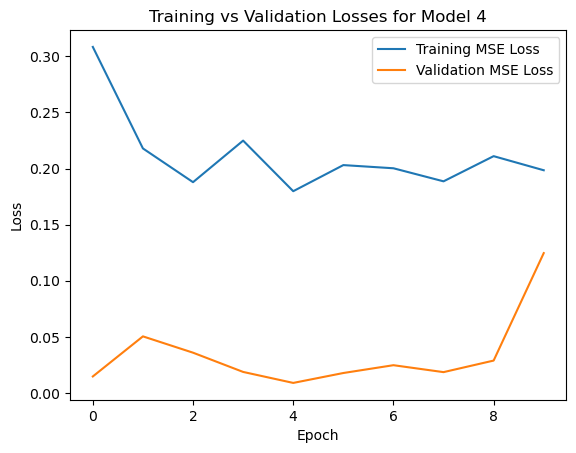

In [102]:
plt.plot(autoencoder_train_loss_four, label='Training MSE Loss')
plt.plot(autoencoder_val_loss_four, label='Validation MSE Loss')
plt.title('Training vs Validation Losses for Model 4')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

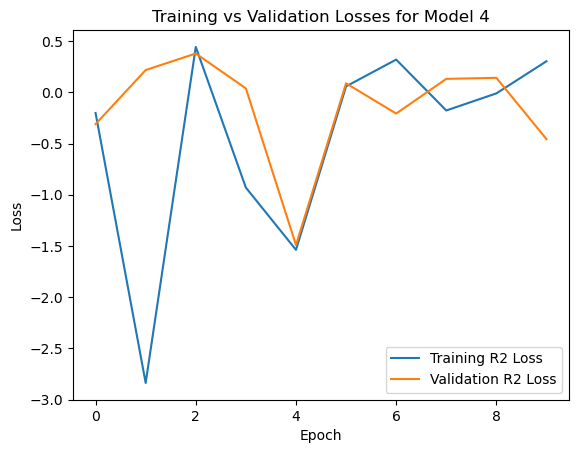

In [105]:
plt.plot(autoencoder_train_r2_loss_four, label='Training R2 Loss')
plt.plot(autoencoder_val_r2_loss_four, label='Validation R2 Loss')
plt.title('Training vs Validation Losses for Model 4')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# References

- https://www.timescale.com/blog/what-is-a-time-series-plot-and-how-can-you-create-one/
- https://www.kaggle.com/code/anseldsouza/harddrive-failures-random-forest
- https://visualstudiomagazine.com/articles/2021/04/13/autoencoder-anomaly-detection.aspx#:~:text=To%20use%20an%20autoencoder%20for,is%20anomalous%20in%20some%20way.
- Part 2 is based on the CSE 574 Machine Learning Assignment 0,1,2,3 and Quiz 5submission by Radhika Singh[rsingh57, 50537855] and CSE 676 Deep Learning Assignment 0,1 Submission by Radhika Singh[rsingh57@buffalo.edu, 50537855]
- https://www.kaggle.com/datasets/backblaze/hard-drive-test-data 
- https://www.kaggle.com/code/ariahanggara/regression-challenge-day-3
- https://www.w3schools.com/python/matplotlib_scatter.asp
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 
- 